In [4]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 


# Set paths
baseDir = os.path.join(os.getcwd(),'..')
codeDir = os.path.join(baseDir, 'code')
dataDir = os.path.join(baseDir, 'data')
stimDir = os.path.join(baseDir, 'BOLD5000_Stimuli_Shared')

N_TUNING_CURVES = 8

qualtricsData = pd.read_csv(os.path.join(dataDir, "qualtricsDataClean.csv"),index_col='participant')
masterData = pd.read_csv(os.path.join(dataDir, "masterDataClean.csv"),low_memory=False,index_col='participant')
lingDirectionsAverage = pd.read_csv(os.path.join(dataDir, "lingDirectionsAverage.csv"),index_col='presentedImage')
lingDirectionsParticipant = pd.read_csv(os.path.join(dataDir, "lingDirectionsParticipant.csv"),index_col=['presentedImage','participant'])
analogDirectionsParticipant = pd.read_csv(os.path.join(dataDir, f'analogData_{N_TUNING_CURVES}_bins_Participant.csv'),index_col=['presentedImage','participant'])
analogDirectionsAverage = pd.read_csv(os.path.join(dataDir, f'analogData_{N_TUNING_CURVES}_bins_Average.csv'),index_col='presentedImage')

files = glob.glob(os.path.join(dataDir,'individualAnalogData','*tuning*16*.csv'),recursive=True)

In [5]:
def reformat_data(file_name):
    
    # Grab the subject ID from the filename
    subj_id = file_name.split('/')[-1][:5]
    
    # Transpose the table so we can use the image names as an index
    processed_data = pd.read_csv(file_name).transpose()
    
    # Drop the images that have no data (subjects did not provide responses to all images; only 100/500)
    #processed_data.dropna(inplace=True)
    # Reformat the index into a multi-index to refer to each image as its name and subject id
    processed_data = pd.concat({subj_id : processed_data}, names=['participant','image'])
    
    return processed_data

# Load the first data file
all_data = reformat_data(files.pop(0))

# For the rest of the files, add them to the whole dataset
for file in files:
    
    subj_data = reformat_data(file)
    all_data = pd.concat([all_data,subj_data])

display(all_data.shape)

(35500, 15)

In [10]:
lingDirectionsParticipant.reset_index(inplace=True)
display(lingDirectionsParticipant)


,presentedImage,participant,ahead,right,left,sharp_right,slight_right,slight_left,sharp_left
0,ATM1.jpg,43851,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ATM1.jpg,44020,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,ATM1.jpg,44124,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ATM1.jpg,44237,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,ATM1.jpg,44386,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
7795,yogastudio4.jpg,44580,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7796,yogastudio4.jpg,44585,0.0,1.0,1.0,1.0,0.0,0.0,1.0
7797,yogastudio4.jpg,44607,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7798,yogastudio4.jpg,44609,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [11]:
from matplotlib.pyplot import cm

def process_tuning_curves(image_name,
                          df,
                          ling_df,
                          im_dir=stimDir,
                          method='pearson',
                          show_plots=False,
                          save_plots=False,
                          out_dir='.',
                          verbose=False,):
    '''
    Takes in the name of an image and plots all tuning curves from each participant
    for that image. 
    
    image_name - string. The name of the image to plot
    df - dataframe generated by the functions above where each entry is the tuning curve data for each subject.

    '''
    
    # Slice just the image data from the df
    image_data = df.xs(image_name, level=1, drop_level=False)
    
    if image_name in ling_df['presentedImage'].values:  
        ling_data = ling_df[ling_df['presentedImage']==image_name].iloc[0,]
        
    else:
        ling_data = pd.DataFrame(data=[[image_name,0,0,0,0,0,0,0]],columns=ling_df.columns).iloc[0,]
        print(image_name)
        
        
    n = image_data.dropna().shape[0]
    color = cm.jet(np.linspace(0, 1, n))
    
    if show_plots or save_plots:
        # Create a figure
        fig, ax = plt.subplots(3,1,figsize=[6,14])
        # Add in the bar plot
        ax[2].bar(ling_df.columns[1:],ling_data[1:],width=1)
        
        
        
    # For each non-nan row (not every subject responded to every image)
    for i,c in zip(range(n),color):

        if show_plots or save_plots:
            # Plot the actual image
            ax[0].imshow(mpimg.imread(os.path.join(im_dir,f'{image_name}')))
                                    
            # Plot the analog data (individual subjects)
            ax[1].plot(image_data.dropna().iloc[i,:], color=c)
            
    # The correlation of each row of that dataframe with every other row
    corr_value = image_data.dropna().corrwith(image_data.dropna().iloc[0], axis=1,method=method)
    
    # Exclude the correlation of that row with itself
    corr_value = corr_value[1:]
    mean_corr = round(corr_value[:].mean(),2)

    if verbose:
        print(f'r-value for {image_name} = {mean_corr:.2f}')
    
    if show_plots or save_plots:
        # Format plots
        #ax[0].title.set_text('Image')
        ax[0].axis('off')

        #ax[1].title.set_text('Analog Data')
        ax[1].set_xlabel('Bin number')
        ax[1].set_ylabel('Proportion of responses')
        maxY = ax[1].get_ylim()[1]
        ax[1].annotate(f'{method} correlation = {mean_corr:.2f}',xy=(0,maxY),xytext=(0,maxY))
        ax[1].spines['right'].set_visible(False)
        ax[1].spines['top'].set_visible(False)
        
        #ax[2].title.set_text('Categorical Data')
        ax[2].set_xlabel('Spatial direction term')
        ax[2].set_ylabel('Proportion of responses')
        ax[2].spines['right'].set_visible(False)
        ax[2].spines['top'].set_visible(False)
    
    if save_plots:
        fig.savefig(os.path.join(out_dir,f'{method}_{mean_corr:.2f}_{image_name[:-4]}_ind_sub_plots.png'))
        
    if show_plots:
        plt.show()
    else:
        plt.close()

            
    return mean_corr


In [34]:

# Get all unique image names
method = 'pearson'
images = all_data.index.unique(level=1)
corr_values = pd.DataFrame()
for i in range(len(images)):
    corr_values.at[images[i],'corr_across_people'] = process_tuning_curves(images[i],
                                           all_data,
                                           lingDirectionsParticipant,
                                           show_plots=False,
                                           save_plots=False,
                                           method=method)

    
corr_values.to_csv(os.path.join(dataDir,'analogData_Correlations_Participant.csv'))

# Pretty up the figures :) 
# Generate varied tuning curves! 

In [36]:
corr_values.to_csv(os.path.join(dataDir,'analogData_Correlations_Participant.csv'))


0.5552400000000006


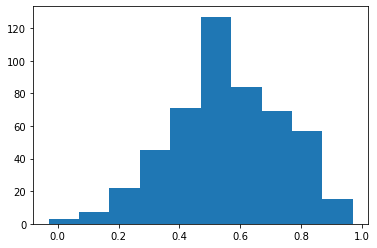

In [36]:
plt.hist(corr_values)
print(corr_values.mean())